# Bird Classification


Importing necessary libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers
from keras_cv.layers import RandomCutout
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\Users\SGORKHAL\.conda\envs\tf_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\SGORKHAL\.conda\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The image size is 500 by 333 pixels


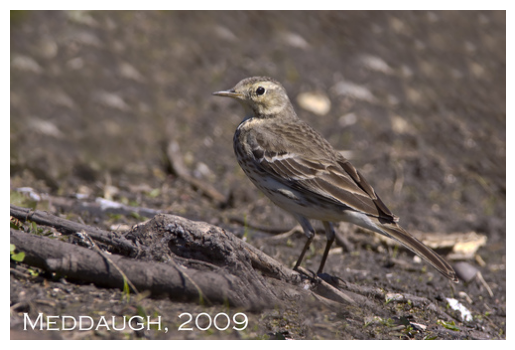

In [2]:
img = Image.open('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\Train\\American_Pipit\\American_Pipit_0006_99857.jpg')
print(f'The image size is {img.size[0]} by {img.size[1]} pixels')
plt.imshow(img)
plt.axis('off')
plt.show()

## 1. Loading and batching the images


In [3]:
base_dir_train = 'C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\Train'
train = image_dataset_from_directory(
    base_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 10,
    seed = 1234,
    #image_size = (224, 224),
    shuffle = True
    )
train_class_names = train.class_names

base_dir_test = 'C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\Test'
test = image_dataset_from_directory(
    base_dir_test,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 10,
    image_size = (224, 224),
    seed =1234
)
test_class_names = test.class_names

Found 9414 files belonging to 200 classes.
Found 2340 files belonging to 198 classes.


In [4]:
test_images = []
true_classes = []

for images, labels in test:
    test_images.append(images.numpy())
    true_classes.append(labels.numpy())

test_images = np.concatenate(test_images)  
true_classes = np.concatenate(true_classes)

print(test_images.shape)     
print(true_classes.shape) 

(2340, 224, 224, 3)
(2340,)


## Exploratory Data Analysis

In [5]:
# Display image to see our images
def display_images(class_names, image_batch, label_batch):
  plt.figure(figsize=(18, 6))
  for i in range(len(image_batch)):
    ax = plt.subplot(1, len(image_batch), i + 1)
    img = image_batch[i].numpy().astype('uint8')
    lbl = class_names[int(label_batch[i])]
    plt.imshow(img)
    plt.title(lbl)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

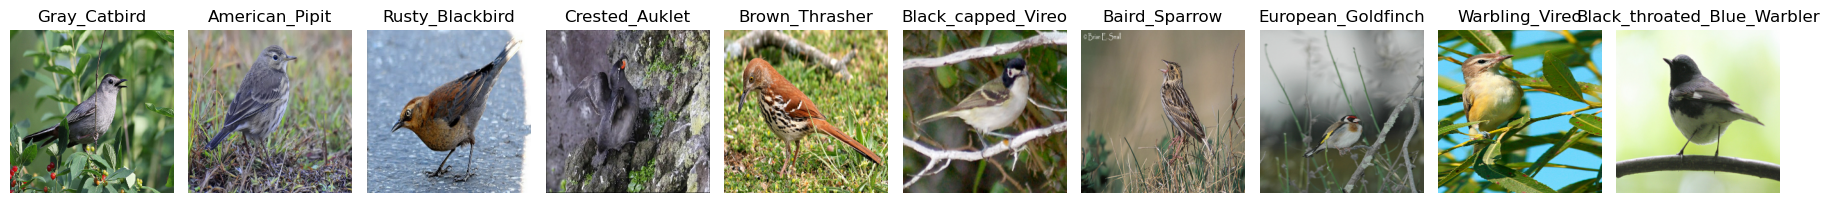

In [6]:
for image_batch, label_batch in train.take(1):
  display_images(train_class_names, image_batch, label_batch)

Lets explore the class distribution of our data. Major class imbalance can affect our CNN model performance when we have multiple class, its can be biased towards majority class as it optimizes for overall Accuracy. We can see high accuracy but low precision and recall.

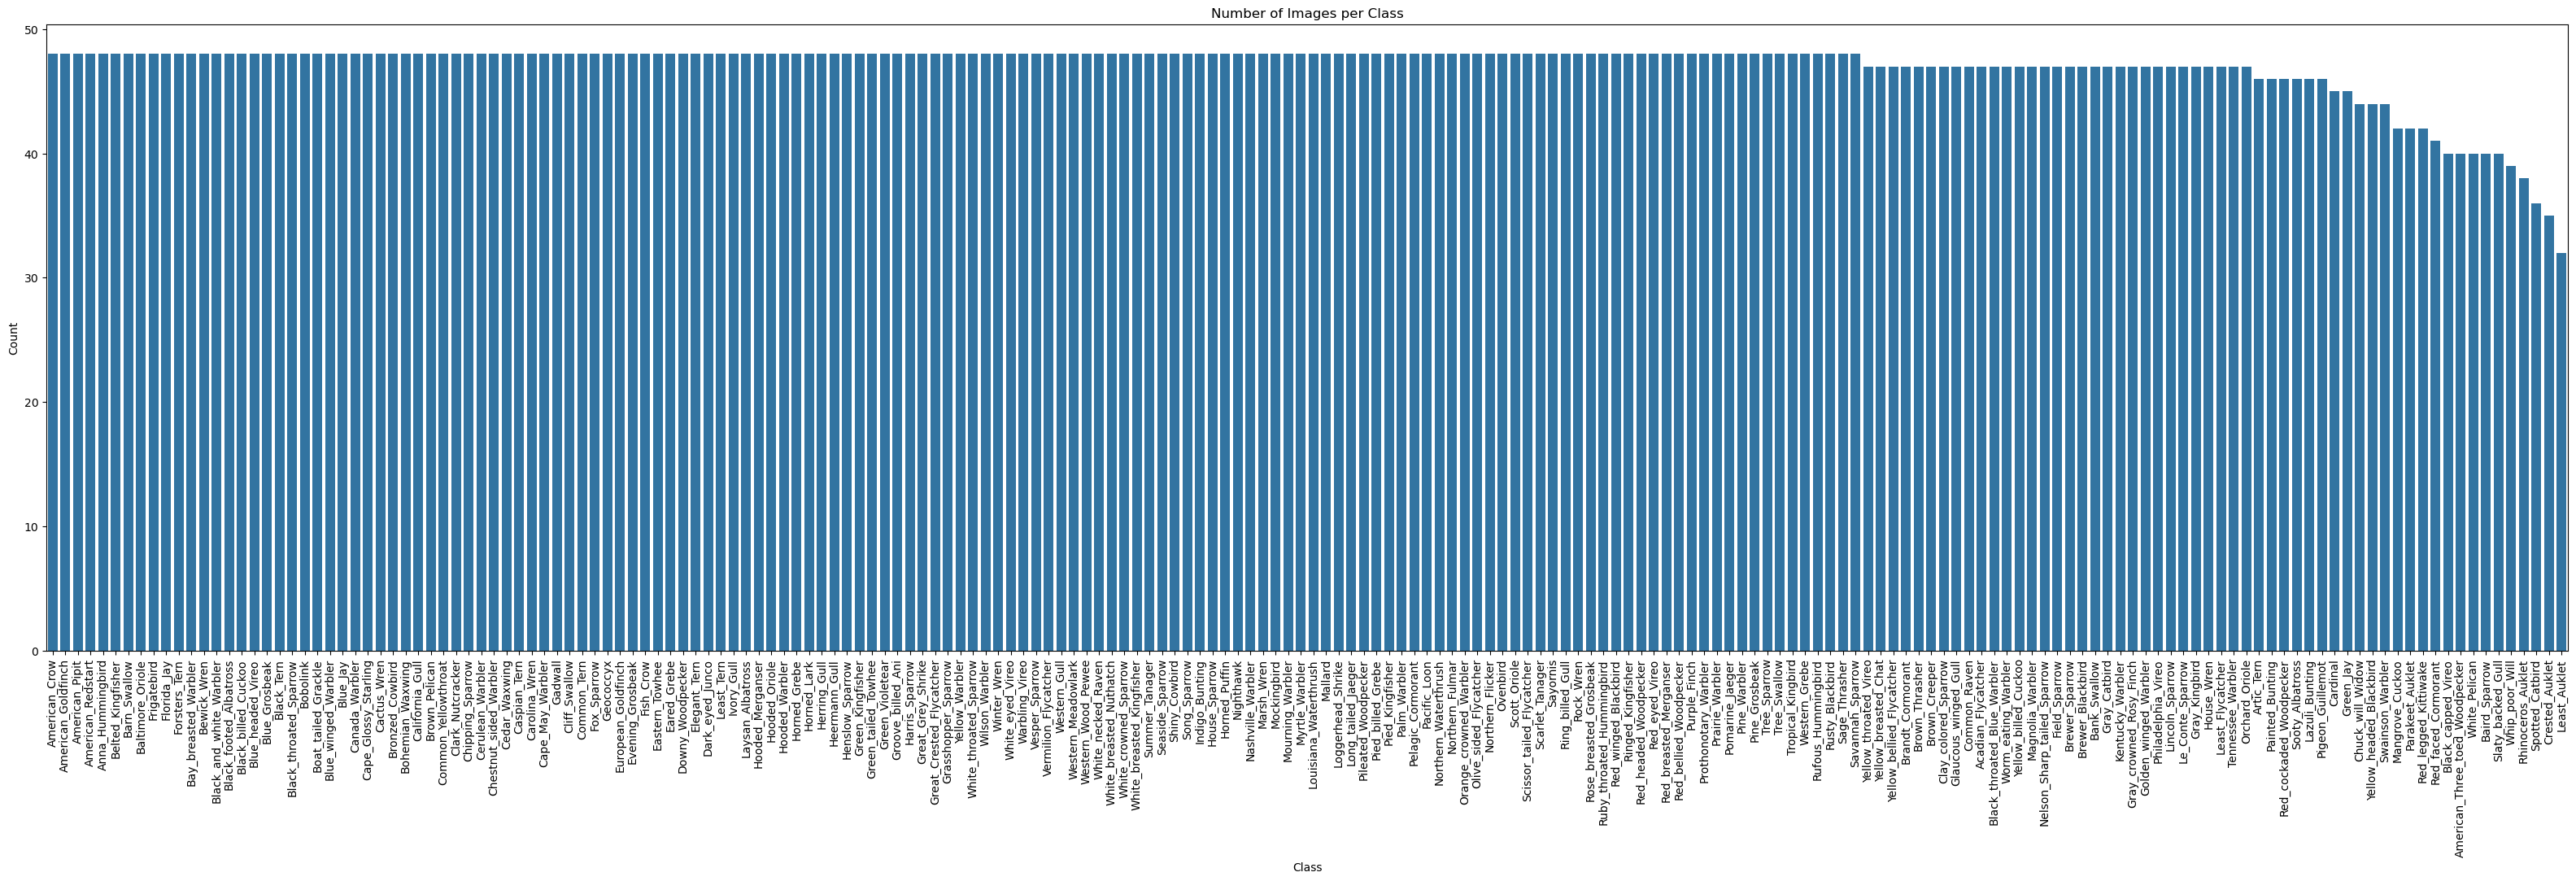

In [7]:
# Exploring class distribution of our data
classes = os.listdir(base_dir_train)

# Count images per class
class_counts = {class_name: len(os.listdir(os.path.join(base_dir_train, class_name)))
                for class_name in classes}

# Plot
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df = df.sort_values(by='Count', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 10))
sns.barplot(data=df, x='Class', y='Count')
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.show()

Overall it seems like our train data is evenly distributed among different class and there is not extremely worrisome class imbalance in any class.



## Pre- processing Images

Cropping and resizing

In [8]:
# Cropping images
cropped_images = image_dataset_from_directory(
    base_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    crop_to_aspect_ratio = True,
    image_size = (224, 224),
    batch_size = 10,
    seed = 1234
)

Found 9414 files belonging to 200 classes.


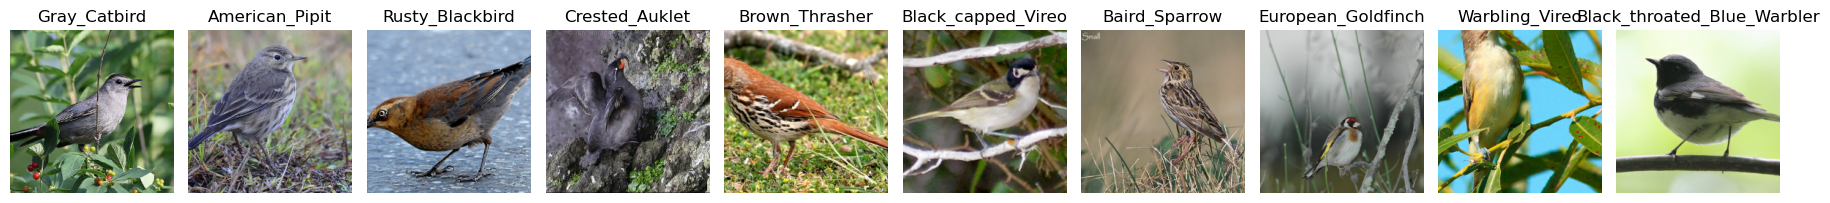

In [9]:
# Lets look at the images after cropping
for image_batch, label_batch in cropped_images.take(1):
  display_images(train_class_names, image_batch, label_batch)


In [10]:
# Spliting into train and validation for cropped image
val_batches = int(0.2 * tf.data.experimental.cardinality(cropped_images).numpy()) # 0.2*total number of batches
cropped_val_ds = cropped_images.take(val_batches)
cropped_train_ds = cropped_images.skip(val_batches)
print("Total batches in cropped train_ds:", tf.data.experimental.cardinality(cropped_train_ds).numpy())
print("Total batches in cropped val_ds:", tf.data.experimental.cardinality(cropped_val_ds).numpy())

Total batches in cropped train_ds: 754
Total batches in cropped val_ds: 188


As we can see, after cropping there are significant images of birds where their head and some cruical parts are cropped so lets also try top train without using crooped and only image size in order to select a good baseline for pre processing steps

In [11]:
no_cropped_images = image_dataset_from_directory(
    base_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224, 224),
    batch_size = 10,
    seed = 1234
)

Found 9414 files belonging to 200 classes.


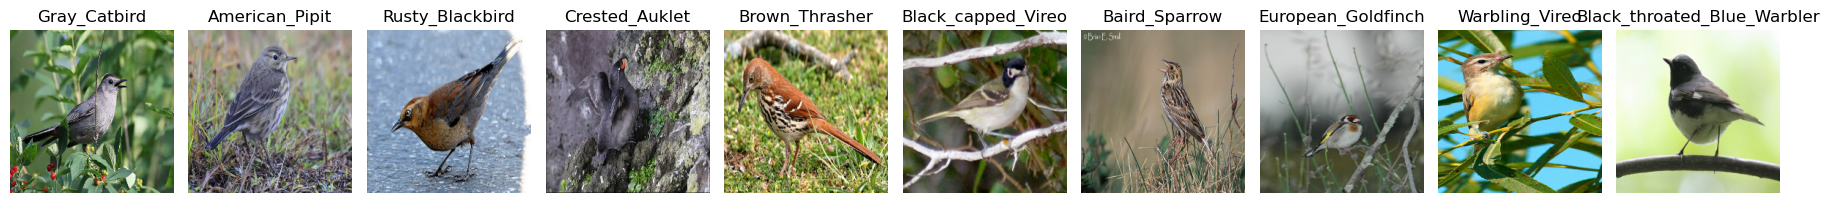

In [12]:
# Lets look at the images with no cropping
for image_batch, label_batch in no_cropped_images.take(1):
  display_images(train_class_names, image_batch, label_batch)


In [13]:
# Split into train and val for not cropped images
val_batches_2 = int(0.2 * tf.data.experimental.cardinality(no_cropped_images).numpy()) # 0.2*total number of batches
no_crop_val_ds = no_cropped_images.take(val_batches_2)
no_crop_train_ds = no_cropped_images.skip(val_batches_2)
print("Total batches in not cropped train_ds:", tf.data.experimental.cardinality(no_crop_train_ds).numpy())
print("Total batches in not cropped val_ds:", tf.data.experimental.cardinality(no_crop_val_ds).numpy())

Total batches in not cropped train_ds: 754
Total batches in not cropped val_ds: 188


Augment images

Adding Augmentation layers to ensure our model doesnot overfit, here i have used random flip, rotation and rand aug does some random change in the color.

RandAugment can apply:
- Color Jitter (brightness, contrast, saturation)
- Sharpness adjustment
- Translate (shifting the image along X or Y axis)
- Cutout (randomly mask out sections of the image)
- AutoContrast (automatic contrast adjustment)
- Shear (geometrical transformation)
- Rotation (rotation of the image)
- Flip (random flipping — horizontal or vertical)
- Invert colors (invert colors of the image)

In [14]:
augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    RandomCutout(
        height_factor = 0.15, 
        width_factor = 0.15,
    
    )
])
        
    #layers.RandAugment(
     #   value_range = (0, 255),
      #  num_ops = 2, # apply 2 augmentation operations
       # factor = 0.1,
        #interpolation = 'bilinear',
        #seed = 1234,
        #augmentations=[
        #'rotate', 'shearX', 'shearY', 'translateX', 'translateY'
    #]
    #)
# ])

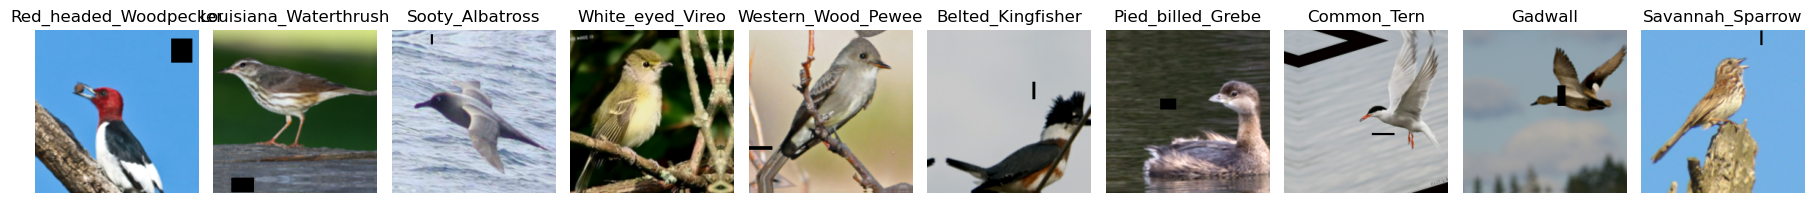

In [15]:
# Train data with augmentation and cropping
cropped_aug_train_ds = cropped_train_ds.map(lambda x, label : (augmentation_layer(x), label))

for image_batch, label_batch in cropped_aug_train_ds.take(1):
  display_images(train_class_names, image_batch, label_batch)

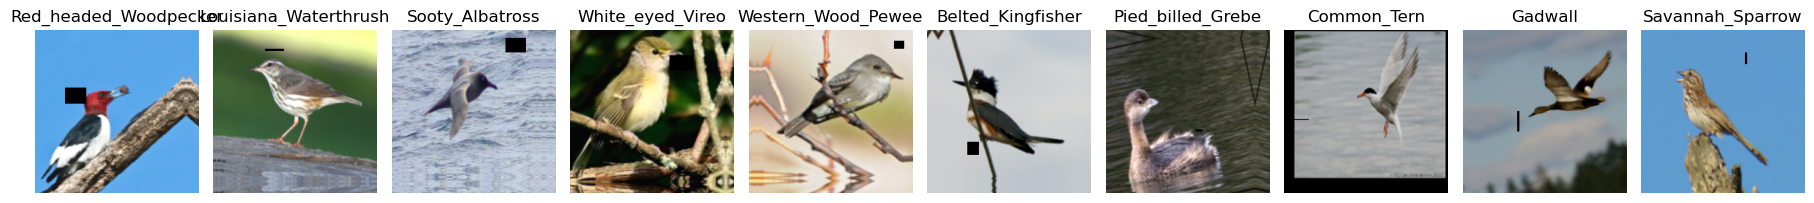

In [16]:
# Train data with aumentation and no cropping 
aug_train_ds = no_crop_train_ds.map(lambda x, label : (augmentation_layer(x), label))

for image_batch, label_batch in aug_train_ds.take(1):
  display_images(train_class_names, image_batch, label_batch)

In [17]:
def create_model():
    model = keras.Sequential([
        keras.Input(shape=(224,224,3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(200, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [18]:
# Model with crop and augmented trainning dataset
model1 = create_model()
crop_and_aug_model = model1.fit(cropped_aug_train_ds,
                    epochs = 20,
                    validation_data = cropped_val_ds)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 190s 245ms/step - accuracy: 0.0065 - loss: 6.1321 - val_accuracy: 0.0261 - val_loss: 5.3525
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 239ms/step - accuracy: 0.0207 - loss: 5.5463 - val_accuracy: 0.0441 - val_loss: 4.9218
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 239ms/step - accuracy: 0.0256 - loss: 5.1691 - val_accuracy: 0.0415 - val_loss: 4.7669
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 182s 240ms/step - accuracy: 0.0430 - loss: 4.9017 - val_accuracy: 0.0447 - val_loss: 4.7480
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 184s 242ms/step - accuracy: 0.0462 - loss: 4.7553 - val_accuracy: 0.0580 - val_loss: 4.5691
Epoch 6/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 185s 243ms/step - accuracy: 0.0631 - loss: 4.5462 - val_accuracy: 0.0691 - val_loss: 4.5877
Epoch 7/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 184s 242ms/step - accuracy: 0.0726 - loss: 4.4369 - val_accuracy: 0.0798 - val_loss: 4.3301
Epoch 8/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 187s 246ms/step - accuracy: 0.0803 -

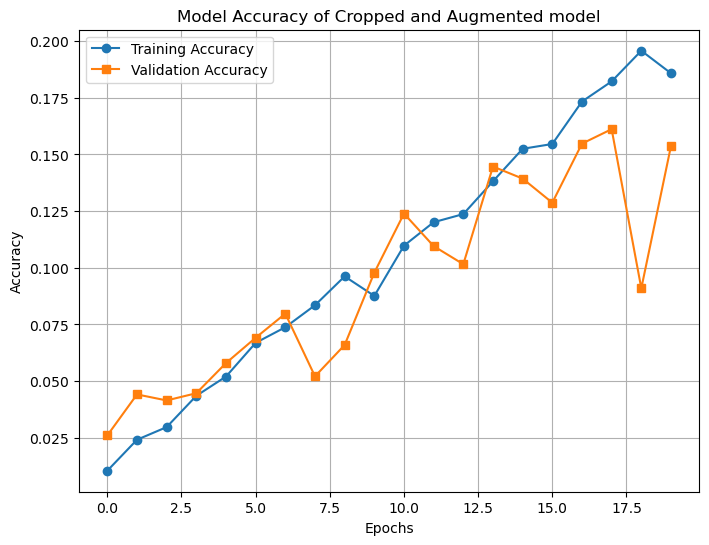

In [19]:
history1 = crop_and_aug_model.history

plt.figure(figsize = (8,6))
plt.plot(history1['accuracy'], label = 'Training Accuracy', marker = 'o')
plt.plot(history1['val_accuracy'], label = 'Validation Accuracy', marker = 's')
plt.xlabel('Epochs')
plt.title('Model Accuracy of Cropped and Augmented model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

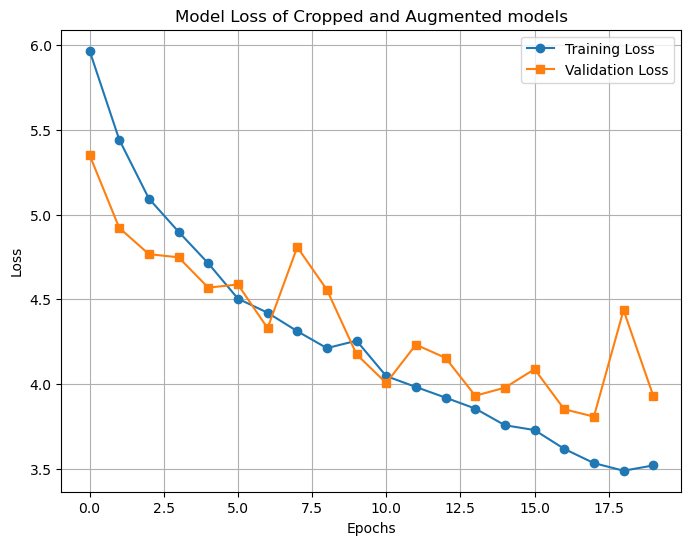

In [20]:
plt.figure(figsize = (8,6))
plt.plot(history1['loss'], label = 'Training Loss', marker = 'o')
plt.plot(history1['val_loss'], label = 'Validation Loss', marker = 's')
plt.xlabel('Epochs')
plt.title('Model Loss of Cropped and Augmented models')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
model1.save('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\base_model_cropandaug.keras')

In [22]:
# Model with no crop and no augmented training dataset
model2 = create_model()
no_crop_no_aug_model = model2.fit(no_crop_train_ds,
                    epochs = 20,
                    validation_data = no_crop_val_ds )

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 174s 226ms/step - accuracy: 0.0095 - loss: 6.1300 - val_accuracy: 0.0394 - val_loss: 5.1292
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 170s 224ms/step - accuracy: 0.0382 - loss: 5.2517 - val_accuracy: 0.0356 - val_loss: 5.0409
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 166s 219ms/step - accuracy: 0.0597 - loss: 4.8399 - val_accuracy: 0.0596 - val_loss: 4.7561
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 169s 223ms/step - accuracy: 0.0834 - loss: 4.4689 - val_accuracy: 0.0394 - val_loss: 4.9205
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 172s 228ms/step - accuracy: 0.1158 - loss: 4.2576 - val_accuracy: 0.0718 - val_loss: 4.6225
Epoch 6/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 239ms/step - accuracy: 0.1674 - loss: 3.7706 - val_accuracy: 0.0771 - val_loss: 4.5474
Epoch 7/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 179s 236ms/step - accuracy: 0.2091 - loss: 3.5633 - val_accuracy: 0.0984 - val_loss: 4.4533
Epoch 8/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 198s 261ms/step - accuracy: 0.3053 -

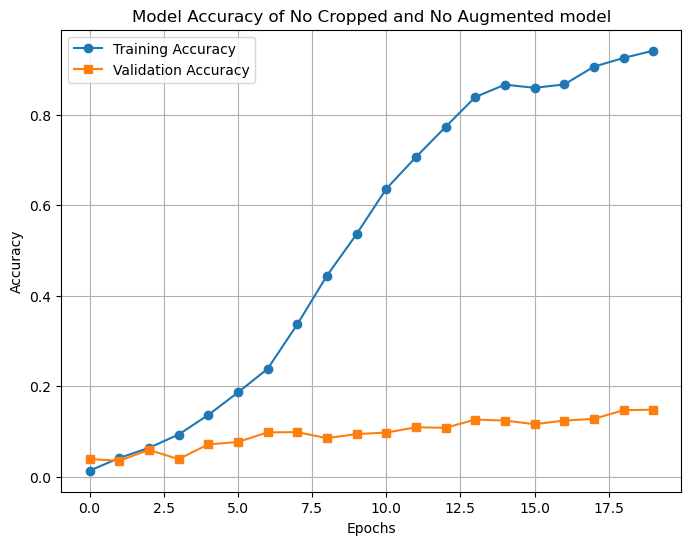

In [23]:
history2 = no_crop_no_aug_model.history

plt.figure(figsize = (8,6))
plt.plot(history2['accuracy'], label = 'Training Accuracy', marker = 'o')
plt.plot(history2['val_accuracy'], label = 'Validation Accuracy', marker = 's')
plt.xlabel('Epochs')
plt.title('Model Accuracy of No Cropped and No Augmented model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

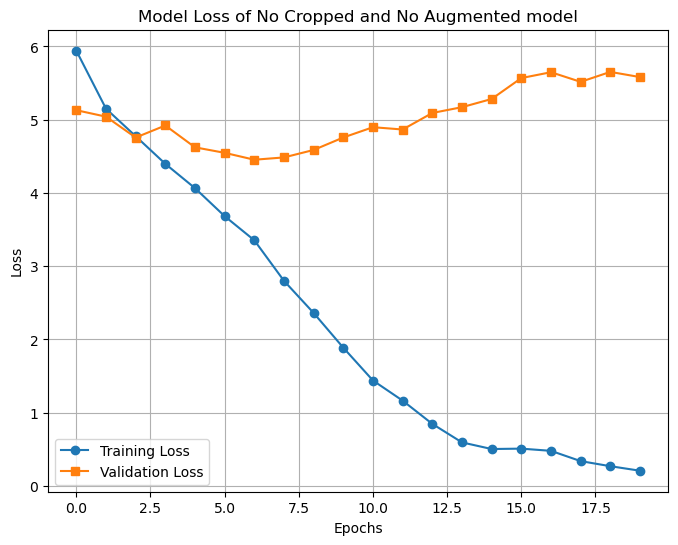

In [24]:
plt.figure(figsize = (8,6))
plt.plot(history2['loss'], label = 'Training Loss', marker = 'o')
plt.plot(history2['val_loss'], label = 'Validation Loss', marker = 's')
plt.xlabel('Epochs')
plt.title('Model Loss of No Cropped and No Augmented model')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
model2.save('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\base_model_nocropandnoaug.keras')

In [26]:
# Model with no crop but augmented training datset
model3 = create_model()
no_crop_yes_aug_model =  model3.fit(aug_train_ds,
                    epochs = 20,
                    validation_data = no_crop_val_ds )

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 194s 250ms/step - accuracy: 0.0081 - loss: 6.1699 - val_accuracy: 0.0234 - val_loss: 5.5101
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 182s 240ms/step - accuracy: 0.0229 - loss: 5.5430 - val_accuracy: 0.0346 - val_loss: 5.0509
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 238ms/step - accuracy: 0.0307 - loss: 5.1724 - val_accuracy: 0.0441 - val_loss: 4.9457
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 239ms/step - accuracy: 0.0451 - loss: 4.8800 - val_accuracy: 0.0585 - val_loss: 4.6427
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 239ms/step - accuracy: 0.0529 - loss: 4.7199 - val_accuracy: 0.0750 - val_loss: 4.4356
Epoch 6/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 187s 246ms/step - accuracy: 0.0633 - loss: 4.5021 - val_accuracy: 0.0745 - val_loss: 4.3737
Epoch 7/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 181s 238ms/step - accuracy: 0.0734 - loss: 4.4167 - val_accuracy: 0.0840 - val_loss: 4.3358
Epoch 8/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 180s 238ms/step - accuracy: 0.0848 -

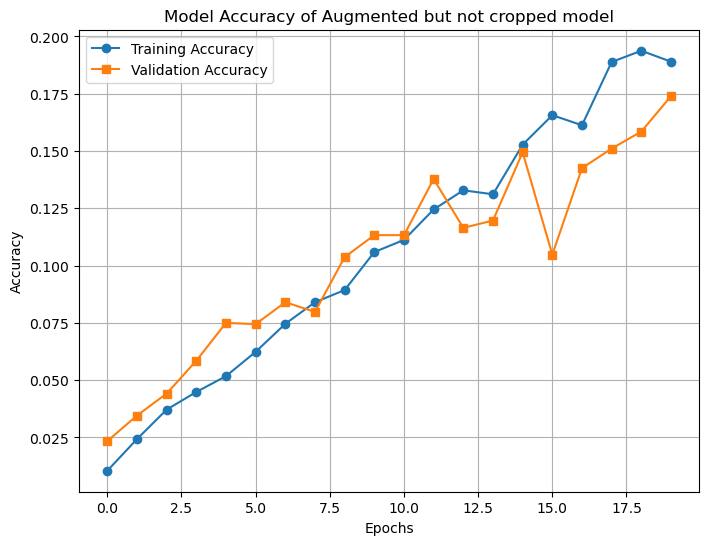

In [27]:
history3 = no_crop_yes_aug_model.history

plt.figure(figsize = (8,6))
plt.plot(history3['accuracy'], label = 'Training Accuracy', marker = 'o')
plt.plot(history3['val_accuracy'], label = 'Validation Accuracy', marker = 's')
plt.xlabel('Epochs')
plt.title('Model Accuracy of Augmented but not cropped model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

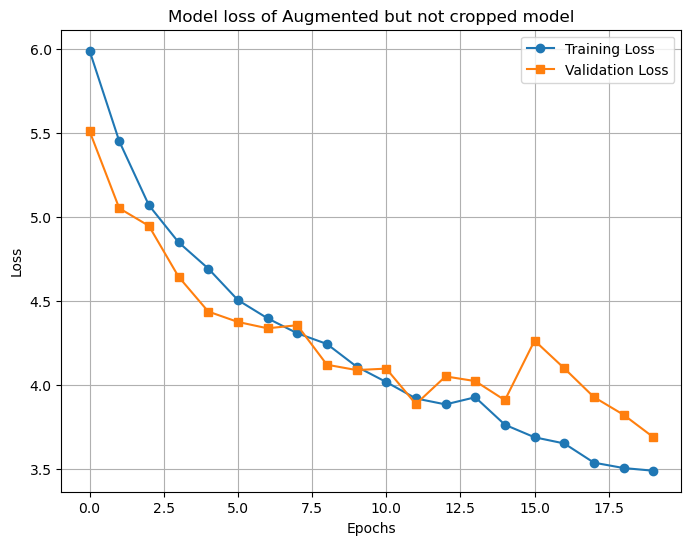

In [28]:
plt.figure(figsize = (8,6))
plt.plot(history3['loss'], label = 'Training Loss', marker = 'o')
plt.plot(history3['val_loss'], label = 'Validation Loss', marker = 's')
plt.xlabel('Epochs')
plt.title('Model loss of Augmented but not cropped model')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
model3.save('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\base_model_nocropandyesaug.keras')

In [30]:
# history2 = model.fit(train_ds,
                   # epochs = 20,
                    #batch_size = 128,
                    #validation_data = val_ds)

Loading models

In [31]:
model1 = keras.models.load_model('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\base_model_cropandaug.keras')

In [32]:
model2 = keras.models.load_model('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\base_model_nocropandnoaug.keras')

In [33]:
model3 = keras.models.load_model('C:\\Users\\SGORKHAL\\OneDrive - DePaul University\\bird-classification\\base_model_nocropandyesaug.keras')

In [34]:
def show_predictions_on_batch(model, dataset, class_names, num_images=5):
    # Get one batch from dataset
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            img = images[i].numpy().astype('uint8')
            plt.imshow(img)
            true_label = class_names[labels[i].numpy()]
            predicted_label = class_names[pred_labels[i]]
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')
        plt.show()

Predictions on training data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


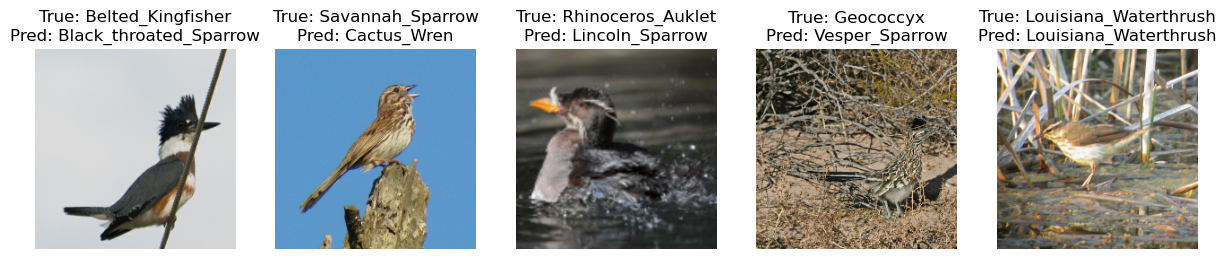

Predictions on validation data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


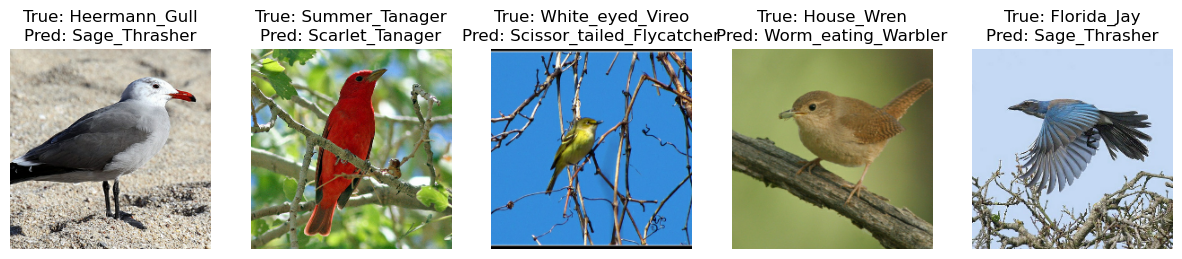

In [35]:
print("Predictions on training data:")
show_predictions_on_batch(model1, cropped_train_ds, train_class_names, num_images = 5)

print("Predictions on validation data:")
show_predictions_on_batch(model1, cropped_val_ds, train_class_names, num_images = 5)

Predictions on training data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


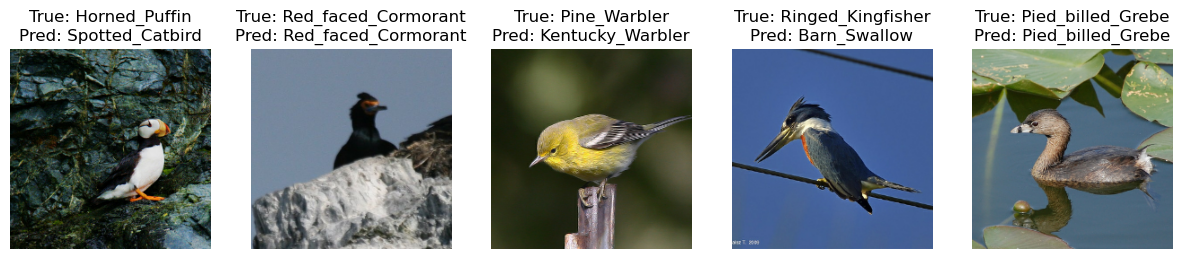

Predictions on validation data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


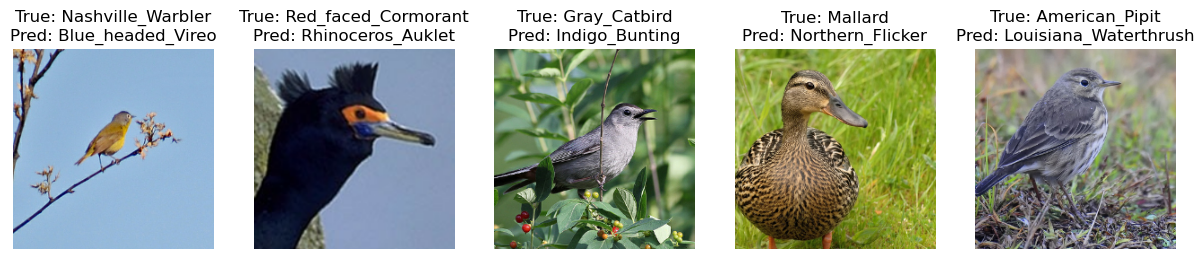

In [36]:
print("Predictions on training data:")
show_predictions_on_batch(model2, cropped_train_ds, train_class_names, num_images = 5)

print("Predictions on validation data:")
show_predictions_on_batch(model2, cropped_val_ds, train_class_names, num_images = 5)

Predictions on training data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


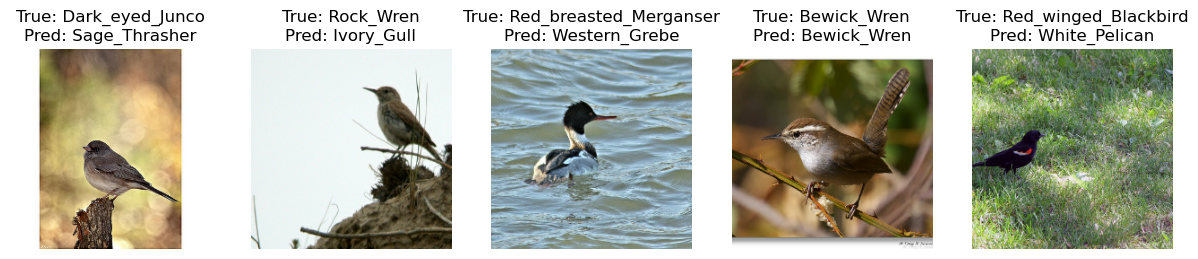

Predictions on validation data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


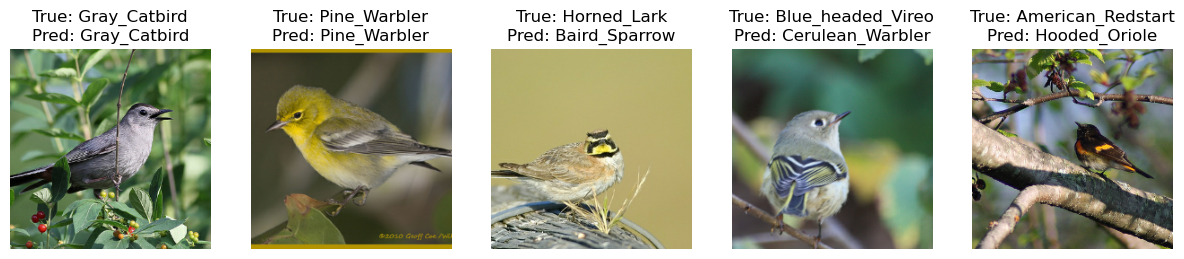

In [37]:
print("Predictions on training data:")
show_predictions_on_batch(model3, cropped_train_ds, train_class_names, num_images = 5)

print("Predictions on validation data:")
show_predictions_on_batch(model3, cropped_val_ds, train_class_names, num_images = 5)

In [38]:
predictions1 = model1.predict(test_images)

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step


predicted_classes = np.argmax(predictions1, axis = 1)
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"The Accuracy of the model on the test images is {accuracy:.4f}")

In [ ]:

def show_images_with_labels(images, true_labels, pred_labels, class_names, num=10):
    plt.figure(figsize=(20, 20))
    for i in range(num):
        ax = plt.subplot(1, num, i+1)
        img = images[i].astype('uint8')
        plt.imshow(img)
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()

# Call the function
show_images_with_labels(test_images, true_classes, predicted_classes, train_class_names, num=10)
